In [55]:
import sys

%load_ext autoreload
%autoreload 1
%aimport pygenesig.validation
%aimport pygenesig.gini
%aimport pygenesig.bioqc
%aimport pygenesig.tools
%aimport pygenesig.perfmeasures
%aimport pygenesig.file_formats
%matplotlib inline

from pygenesig.validation import * 
from pygenesig.gini import * 
from pygenesig.bioqc import * 
from pygenesig.tools import * 
from pygenesig.file_formats import * 
import pygenesig.perfmeasures as pm
import numpy as np
import pandas as pd
import sklearn
import sklearn.metrics as skm 
import os.path
import dask
from dask import compute
import tempfile
from collections import Counter

import seaborn as sns
sns.set_style("ticks", {"axes.grid" : True})
from pylab import * 

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Crossvalidation of gini-signature on the GTEx dataset
In this document, we perform a 10-fold cross-validation of signature generation with gini-index. 

## Use dask for parallel computation

In [2]:
expr_file = "../data_processed/v3/exprs_processed.npy"
target_file = "../data_processed/v3/target.csv"
fdata_file = "../data/v3/roche_annotated_fdata.tsv"
n_splits = 10 
splitter = sklearn.model_selection.StratifiedKFold(n_splits=n_splits)
signature_generator = GiniSignatureGenerator
signature_tester = BioQCSignatureTester
sg_kwargs = {"min_gini": .8, "max_rk": 3, "min_expr": 5, "aggregate_fun": np.median}
st_kwargs = {}

In [3]:
target = read_target(target_file)
exprs = read_expr(expr_file)
fdata = pd.read_csv(fdata_file, sep="\t")

In [4]:
## Remove tissues which have not enough samples and save the new target and expression matrix to a temporary file. 
exprs_fil, target_fil = filter_samples(exprs, target, n_splits=10)
exprs_tmp = tempfile.NamedTemporaryFile(delete=False, dir="../results/tmp", suffix=".npy")
target_tmp = tempfile.NamedTemporaryFile(delete=False, dir="../results/tmp", suffix=".csv")
write_expr(exprs_fil, exprs_tmp.name)
write_target(target_fil, target_tmp.name)
exprs_tmp.close()
target_tmp.close()

In [5]:
exprs_tmp.name

'/pstore/home/sturmg/projects/gtex-signatures/results/tmp/tmpx180l45m.npy'

The following tissues have been removed because they have less than 10 samples:

In [6]:
set(target) - set(target_fil)

{'Artery_Coronary',
 'Fallopian_Tube',
 'Kidney_Cortex',
 'Liver',
 'Ovary',
 'Prostate',
 'Uterus',
 'Vagina'}

In [63]:
target = target_fil
exprs = exprs_fil
st = signature_tester(exprs, target, **st_kwargs)
sg = signature_generator(exprs, target, **sg_kwargs)

In [8]:
sig_list, res_list, train_list, test_list = cv_score(exprs_tmp.name,
                                                    target_tmp.name,
                                                    signature_generator,
                                                    signature_tester,
                                                    splitter,
                                                    sg_kwargs=sg_kwargs)

This is the dask compute graph executed internally: 

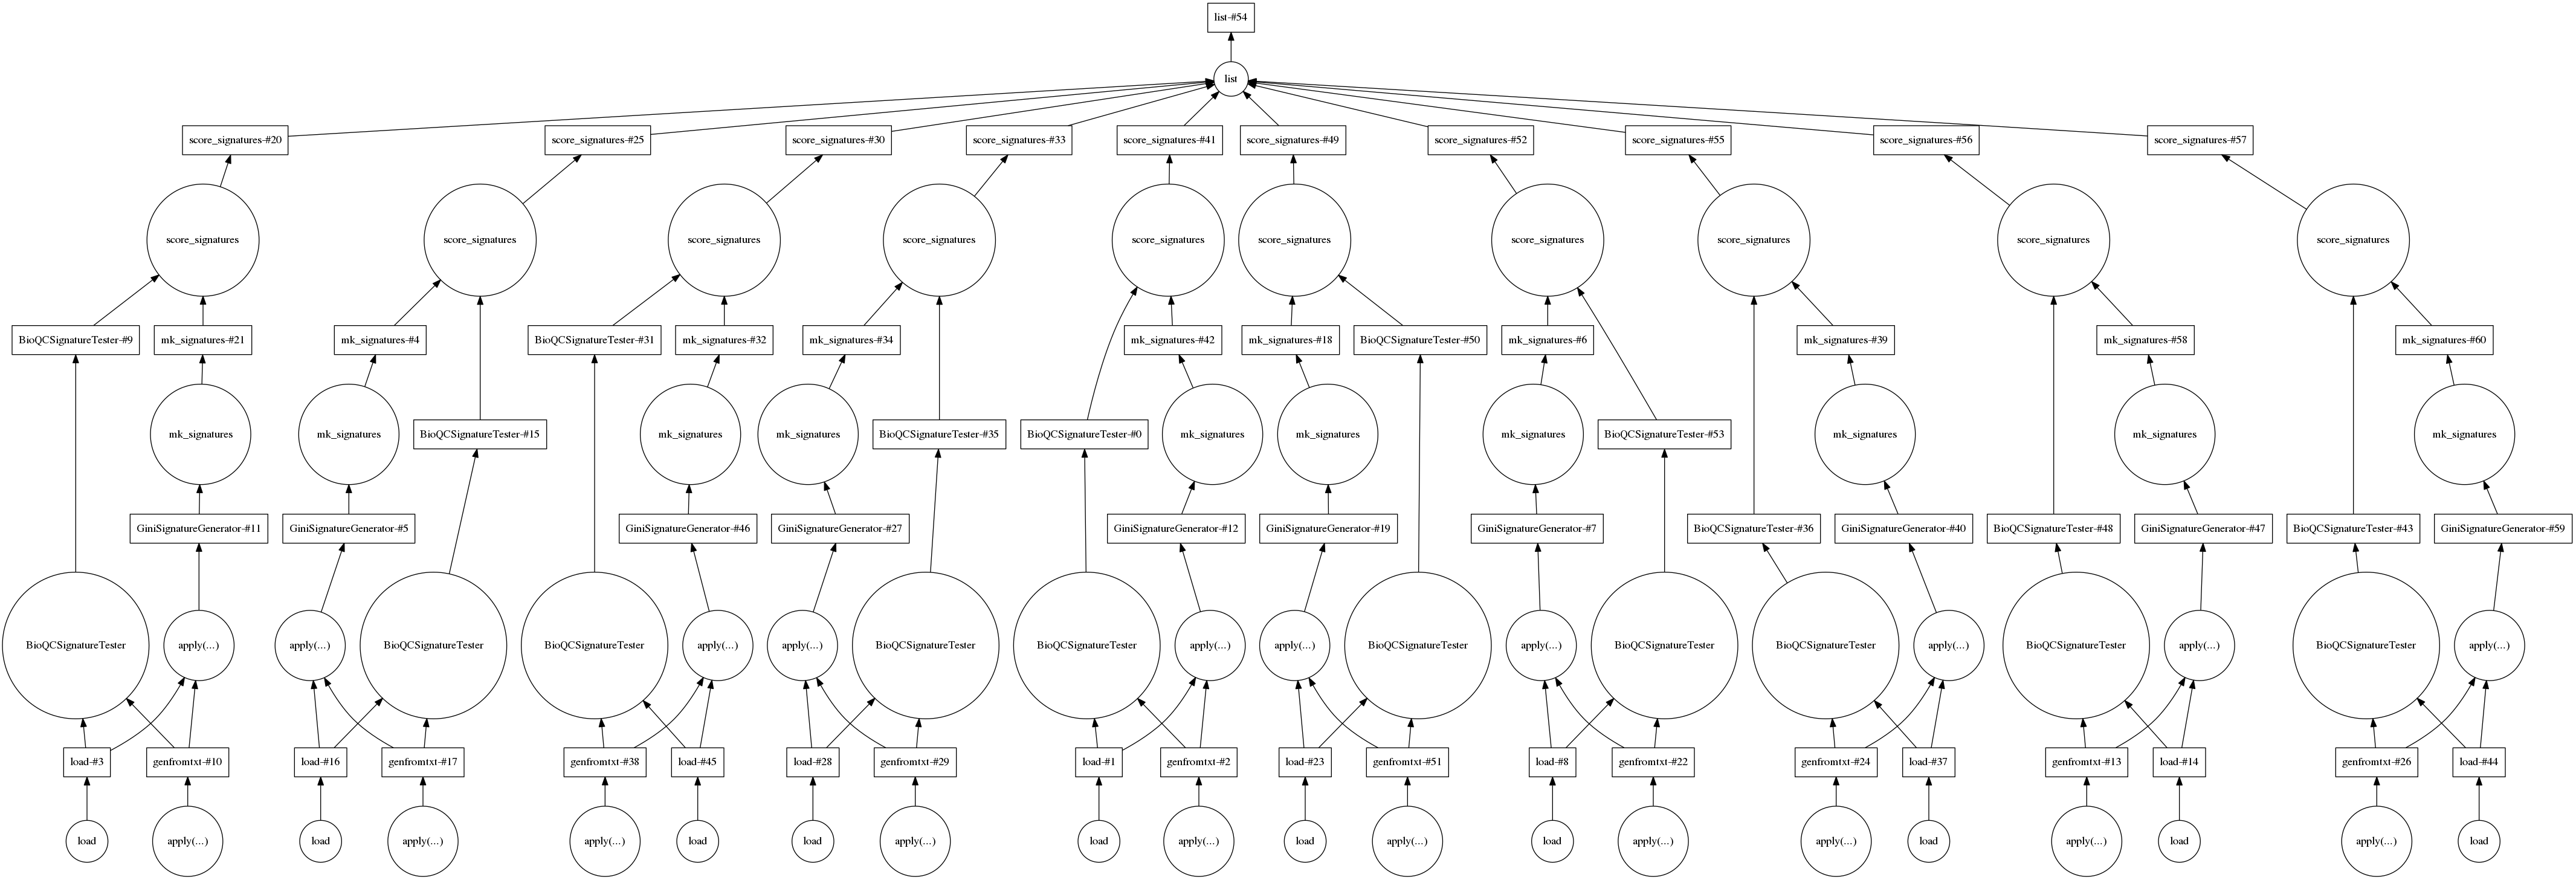

In [9]:
res_list.visualize()

Do the actual computation:

In [10]:
signatures, scores, train_inds, test_inds = compute(sig_list, res_list, train_list, test_list, get=dask.multiprocessing.get)

In [11]:
heatmaps = []
for i, test in enumerate(test_inds):
    sig_labels = signature_tester.sort_signatures(signatures[i])
    scores_df = pd.DataFrame(np.transpose(scores[i]))
    scores_df.columns = sig_labels
    scores_df = scores_df.assign(tissue=pd.Series(target[test]))
    scores_per_sig = scores_df.groupby('tissue').mean().transpose()
    heatmaps.append(scores_per_sig)

In [12]:
heatmap_avg = np.mean([hm.as_matrix() for hm in heatmaps], axis=0)

In [13]:
heatmap_df = pd.DataFrame(heatmap_avg)
heatmap_df.index = heatmaps[0].index
heatmap_df.columns = heatmaps[0].columns

In [14]:
def heatmap_figsize(nrow, ncol=None):
    if ncol is None:
        ncol = nrow
    return (ncol * 0.3 + 3, nrow * 0.3)

## Heatmap of scores, clipped at Score=30

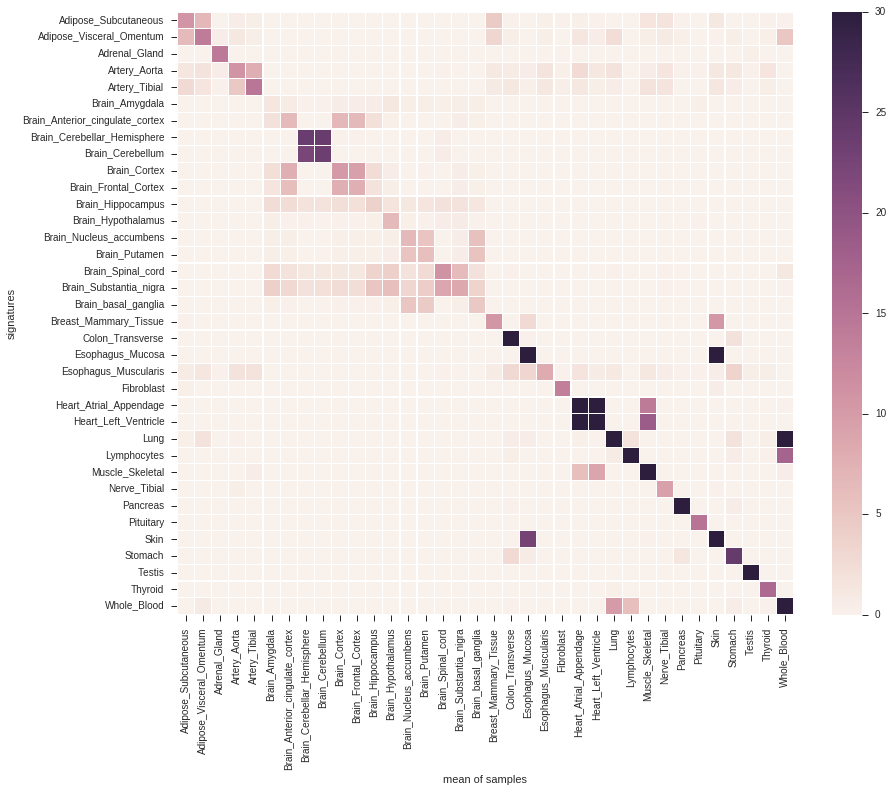

In [15]:
fig, ax = subplots(figsize=heatmap_figsize(len(set(target))))
sns.heatmap(heatmap_df, ax=ax, annot=False, annot_kws={"size": 9}, vmin=0, linewidths=.2, vmax=30);
ax.set_ylabel("signatures")
ax.set_xlabel("mean of samples")

## Heatmap of Classification (Confusion Matrix)

In [32]:
actual_predicted = [st.classify(signatures[0], score, subset) for score, subset in zip(scores, test_inds)]

In [33]:
cms = [st.confusion_matrix(signatures[0], actual, predicted) for actual, predicted in actual_predicted]

In [38]:
conf_mat_mean = np.apply_along_axis(normalize_sum, 1, np.mean(np.array(cms), axis=0)) * 100
sig_labels = BioQCSignatureTester.sort_signatures(signatures[0])

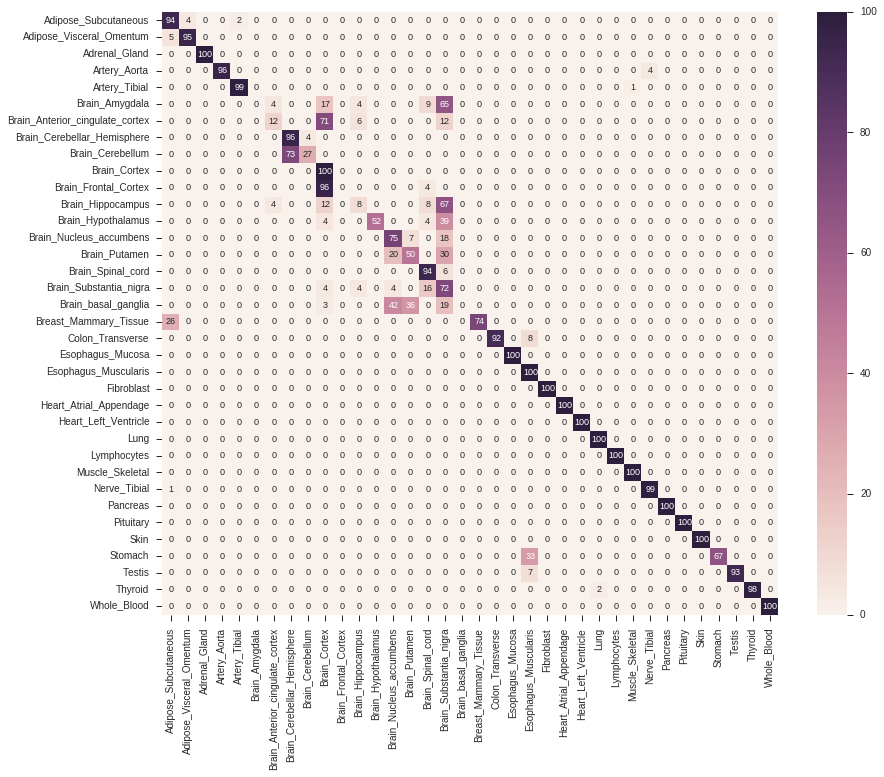

In [46]:
fig, ax = subplots(figsize=heatmap_figsize(len(set(target))))
sns.heatmap(conf_mat_mean, ax=ax, xticklabels=sig_labels, yticklabels=sig_labels, annot=True,annot_kws={"size": 9}, fmt=".0f", vmin=0, vmax=100);

## Median Performance on all folds

In [50]:
prec = performance_per_tissue(cms, sig_labels, pm.prec_pos)
recall = performance_per_tissue(cms, sig_labels, pm.sens)

/pstore/home/sturmg/projects/pygenesig/pygenesig/perfmeasures.py:38: RuntimeWarning: invalid value encountered in true_divide
  return np.divide(TP, (TP + FP))


In [54]:
prec["Brain_Cerebellum"]

[nan, 1.0, 1.0, nan, nan, 1.0, 0.5, 1.0, nan, 1.0]

In [51]:
prec_median = {tissue: np.median(perf) for tissue, perf in prec.items()}
recall_median = {tissue: np.median(perf) for tissue, perf in recall.items()}

/pstore/home/sturmg/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:3569: RuntimeWarning: Invalid value encountered in median
  RuntimeWarning)


In [52]:
pd.DataFrame().assign(Precision=pd.Series(prec_median), Recall=pd.Series(recall_median))

,Precision,Recall
Adipose_Subcutaneous,0.950000,0.950000
Adipose_Visceral_Omentum,1.000000,1.000000
Adrenal_Gland,1.000000,1.000000
Artery_Aorta,1.000000,1.000000
Artery_Tibial,1.000000,1.000000
Brain_Amygdala,NaN,0.000000
Brain_Anterior_cingulate_cortex,NaN,0.000000
Brain_Cerebellar_Hemisphere,0.500000,1.000000
Brain_Cerebellum,NaN,0.333333
Brain_Cortex,0.354167,1.000000


## Signature overlap between the folds
The box-plot shows the overlap of the signatures between the different folds. A high jaccard index indicates stability of the signatures between the folds. 

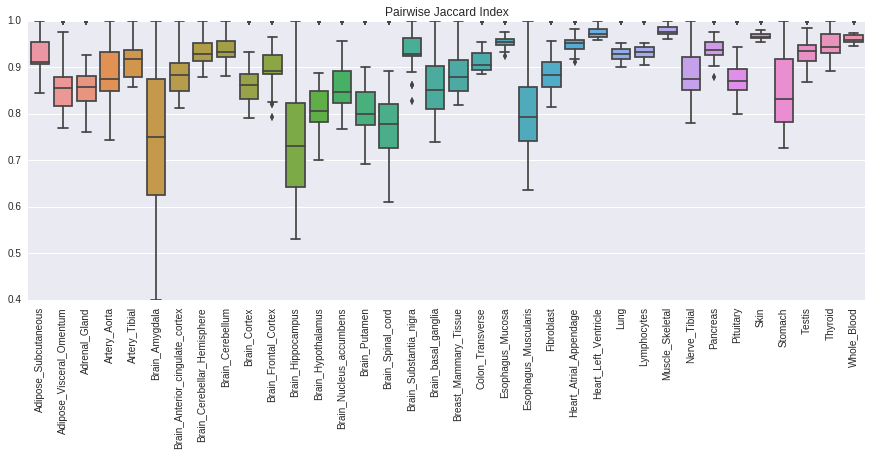

In [46]:
pairwise_jaccard = pairwise_jaccard_ind(signatures)
fig, ax = subplots(figsize=(15,5))
data=pd.DataFrame(pairwise_jaccard)
sns.boxplot(data=data, ax=ax)
ax.set_title("Pairwise Jaccard Index")
ax.set_xticklabels(data.columns, rotation=90);

### Export intersection of folds as signatures

In [60]:
rosetta = dict(enumerate(fdata.GeneSymbol))

In [62]:
sigs_combined = combine_signatures(*signatures)
sigs_combined_hgnc = translate_signatures(sigs_combined, rosetta)

## Export signatures

In [64]:
signatures = sg.mk_signatures()

In [65]:
scores = st.score_signatures(signatures)

In [66]:
scores_df = pd.DataFrame(np.transpose(scores))
scores_df.columns = signature_tester.sort_signatures(signatures)
scores_df['tissue'] = pd.Series(target)
scores_per_sig = scores_df.groupby('tissue').median().transpose()

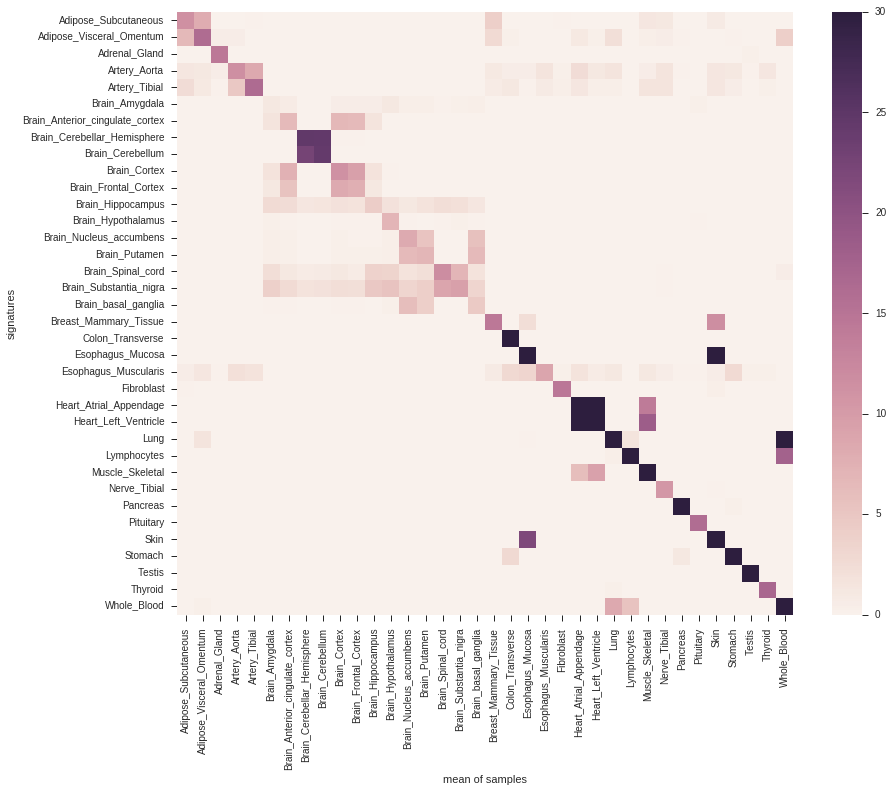

In [69]:
fig, ax = subplots(figsize=heatmap_figsize(len(signatures)))
sns.heatmap(scores_per_sig, ax=ax, annot=False, annot_kws={"size": 9}, vmin=0, vmax=30);
ax.set_ylabel("signatures")
ax.set_xlabel("mean of samples")

## Overlap between tissue signatures
(pairwise jaccard index)

In [84]:
jac_mat = jaccard_mat(signatures_hgnc, signatures_hgnc, as_matrix=True)

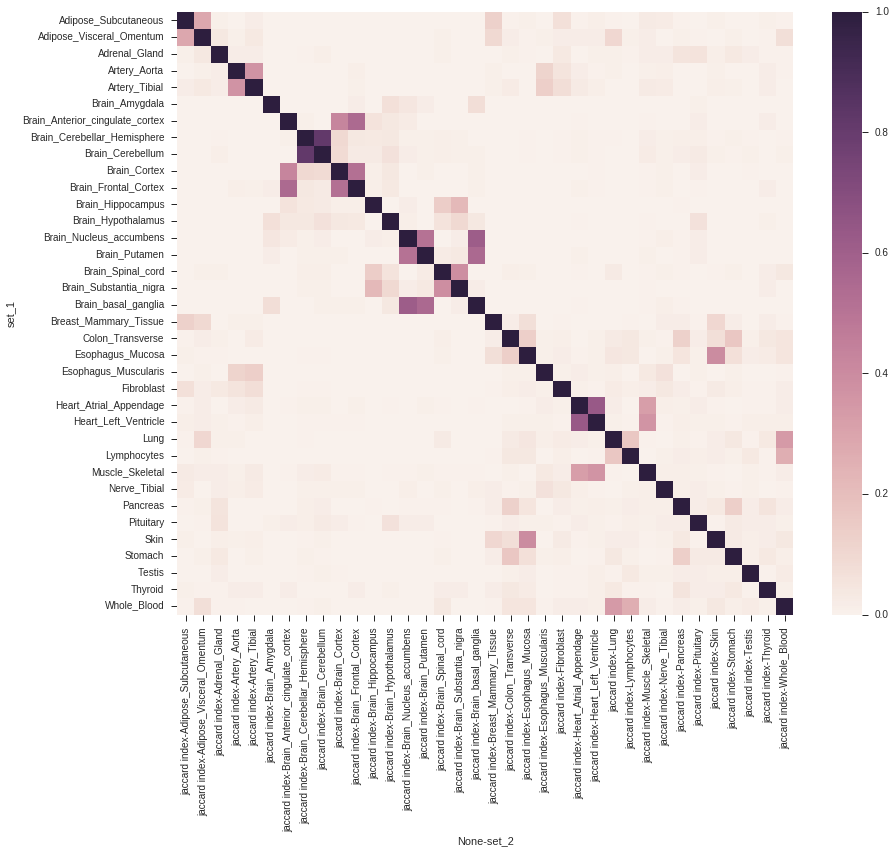

In [85]:
fig, ax = subplots(figsize=heatmap_figsize(len(signatures)))
sns.heatmap(jac_mat, ax=ax)

In [86]:
signatures_hgnc = translate_signatures(signatures, rosetta)

In [87]:
write_gmt(signatures_hgnc, "../results/gtex_0.8_3.gmt")
write_gmt(sigs_combined_hgnc, "../results/gtex_0.8_3_fold_intersection.gmt")

## signature sizes

In [96]:
pd.DataFrame().assign(normal=pd.Series({
        tissue: len(genes) for tissue, genes in signatures_hgnc.items()}), 
                     fold_overlap=pd.Series({tissue:len(genes) for tissue, genes in sigs_combined_hgnc.items()}))

,fold_overlap,normal
Adipose_Subcutaneous,38,43
Adipose_Visceral_Omentum,64,78
Adrenal_Gland,53,65
Artery_Aorta,26,30
Artery_Tibial,41,48
Brain_Amygdala,4,7
Brain_Anterior_cingulate_cortex,36,41
Brain_Cerebellar_Hemisphere,69,81
Brain_Cerebellum,78,90
Brain_Cortex,46,59
